# Slope estimation: comparison of methods

## Author: F. Brandolin

This notebook compares different methods for the estimation of local slopes ($p=dt/dx$) from seismic data:

- Analytical: this is possible for our specific choice of data (i.e., hyperbolic events) as we can represent the data with a analytical time-space relationship and therefore we can also analytically compute the slopes;

- Structure tensor: this is a commonly used technique that estimates local slopes in any image from their local gradients;

- Plane-wave destruction filters (PWD): non-linear least-squares approach for local slope estimation under plane-wave approximation.

- PINNslope: slope estimation with PINNs with automatic differentiation, still under the plane-wave approximation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy import signal, ndimage
from pylops.utils.wavelets import ricker

from signal_sep_pinns.plotting import plotting_style
from signal_sep_pinns.slopes import analytic_local_slope, structure_tensor

plotting_style()

Let's start by creating our dataset composed of hyperbolic events.

In [2]:
par = {"ox": 0, "dx": 5, "nx": 151,
       "ot": 0, "dt": 0.004, "nt": 501,
       "oy": 0, "dy": 0, "ny": 0,
       "f0": 20, "nfmax": 210,}

nt, nx = par["nt"], par["nx"]
dt, dx = par["dt"], par["dx"]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(np.arange(41) * dt, f0=par["f0"])[0]

# Define velocity hyperbolic events
v0=800
kv=200
t0 = np.linspace(0., 1.8, 12)
vrms = v0 + kv * t0

# Create data
amp = np.ones(len(t0))
_, data = pylops.utils.seismicevents.hyperbolic2d(x, t, t0, vrms, amp, wav)

# Define traveltime curve along which slopes will be compared
ievent =  4 # event to track

tevent = np.sqrt(t0[ievent] ** 2 + x ** 2 / vrms[ievent] ** 2)
itevent = np.round(tevent/dt).astype(np.int64)

## Analytical slopes

In [3]:
analytical_slope = analytic_local_slope(data, dt, x, v0, kv);

/home/brandof/Documents/PINNs_signal_separation/signal_sep_pinns/slopes.py:66: RuntimeWarning: invalid value encountered in scalar divide
  slope[it, ix] = x[ix] / (tapp * (v_rms[it0])**2)


## Structure tensor

In [4]:
slope_st = (-1/1000) * structure_tensor(data.T, dt*1000, dx, smooth=10)[0]

## PINNslope and PWD


In [5]:
PINNslope_no_scaling = np.load('../data/synthetic_slope_comp/PINNslope.npy')
PINNslope=(nt/nx)*(dt/dx)*PINNslope_no_scaling

pwd_no_scaling = np.load("../data/synthetic_slope_comp/PWD.npy")
pwd = (dt/dx)*pwd_no_scaling

## Final comparison

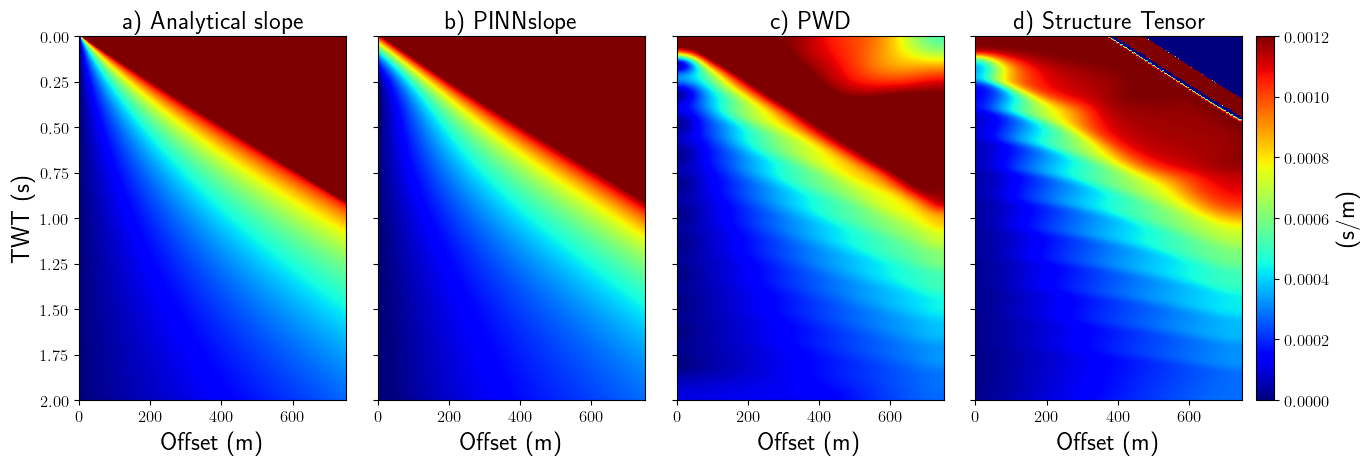

In [6]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14, 5))

ans = axs[0].imshow(analytical_slope, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('a) Analytical slope')
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].axis('tight')

st = axs[3].imshow(slope_st, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[3].set_xlabel('Offset (m)')
axs[3].set_title('d) Structure Tensor')
axs[3].axis('tight')

pwdcmap = axs[2].imshow(pwd, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('c) PWD')
axs[2].axis('tight')

pinnslopcmap=axs[1].imshow(PINNslope, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('b) PINNslope')
axs[1].axis('tight')

cb=axs[3].inset_axes([1.05, 0, .07, 1])
cbar = fig.colorbar(ans, cax=cb)
cbar.set_label('(s/m)')
plt.tight_layout()

plt.show()

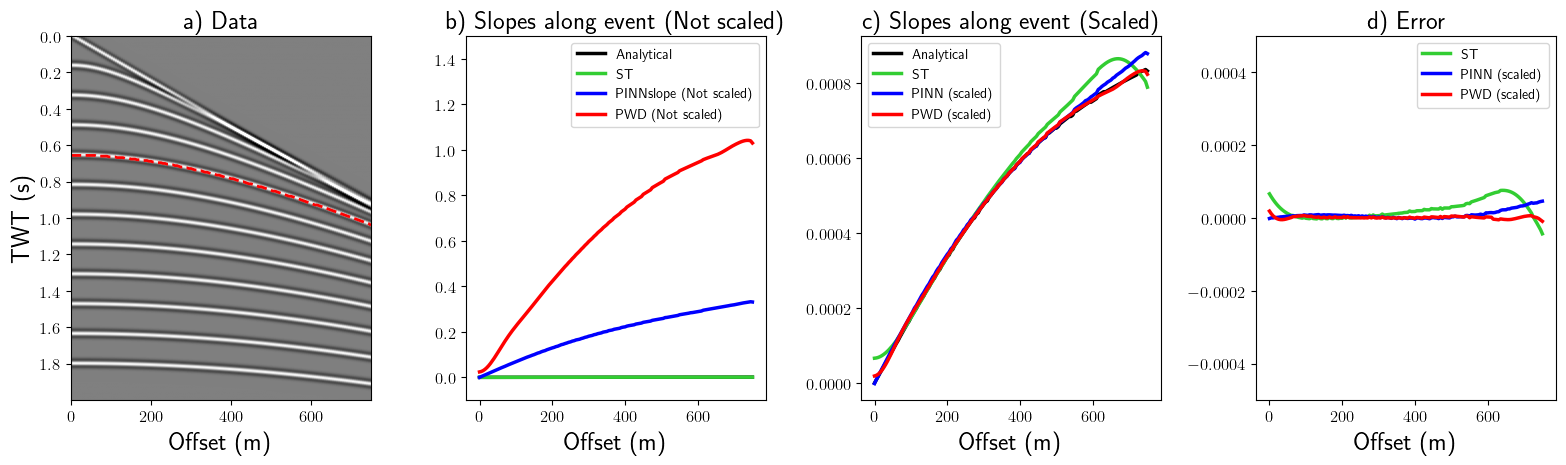

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].plot(x, t[itevent], 'r--', lw=2)
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('a) Data')
axs[0].set_yticks(np.arange(0,2,.2))
axs[0].axis('tight')

axs[1].plot(x, analytical_slope[itevent, np.arange(nx)], 'k', label='Analytical', linewidth=2.5)
axs[1].plot(x, slope_st[itevent, np.arange(nx)], 'limegreen', label='ST',  linewidth=2.5)
axs[1].plot(x, PINNslope_no_scaling[itevent, np.arange(nx)], 'blue', label='PINNslope (Not scaled)', linewidth=2.5)
axs[1].plot(x, pwd_no_scaling[itevent, np.arange(nx)], 'r', label='PWD (Not scaled)', linewidth=2.5)
axs[1].set_title('b) Slopes along event (Not scaled)')
axs[1].set_xlabel('Offset (m)')
axs[1].legend()
axs[1].set_ylim(-.1, 1.5)

axs[2].plot(x, analytical_slope[itevent, np.arange(nx)], 'k', label='Analytical', linewidth=2.5)
axs[2].plot(x,slope_st[itevent, np.arange(nx)], 'limegreen', label='ST', linewidth=2.5)
axs[2].plot(x,PINNslope[itevent, np.arange(nx)], 'b', label='PINN (scaled)', linewidth=2.5)
axs[2].plot(x,pwd[itevent, np.arange(nx)], 'r', label='PWD (scaled)',  linewidth=2.5)
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('c) Slopes along event (Scaled)')
axs[2].legend()

axs[3].plot(x, slope_st[itevent, np.arange(nx)]-analytical_slope[itevent, np.arange(nx)], 'limegreen', label='ST', linewidth=2.5)
axs[3].plot(x, PINNslope[itevent, np.arange(nx)]-analytical_slope[itevent, np.arange(nx)], 'blue', label='PINN (scaled)', linewidth=2.5)
axs[3].plot(x, pwd[itevent, np.arange(nx)]-analytical_slope[itevent, np.arange(nx)], 'r', label='PWD (scaled)',  linewidth=2.5)
axs[3].set_title('d) Error')
axs[3].set_xlabel('Offset (m)')
axs[3].set_ylim(-.0005, .0005)
axs[3].legend()
plt.tight_layout()
plt.show()

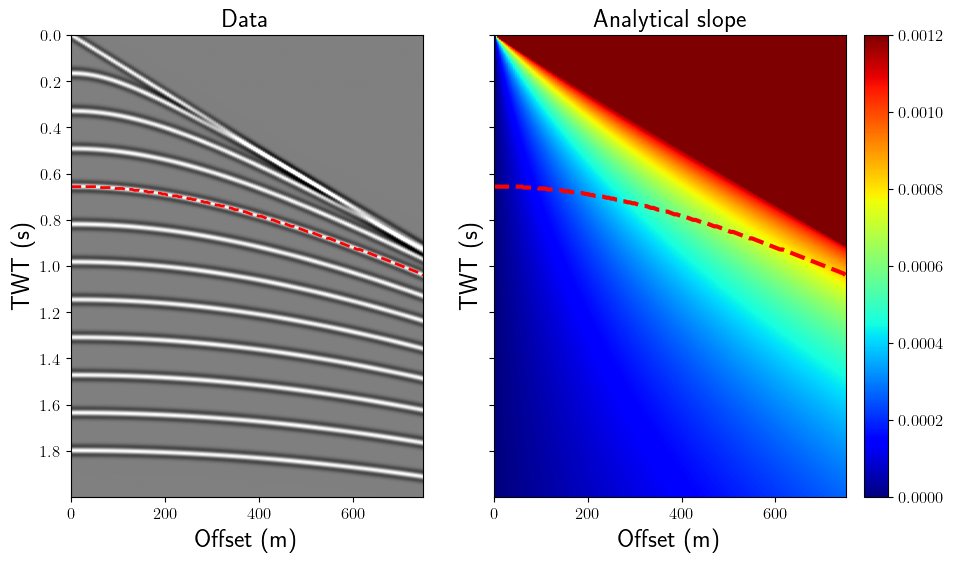

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6),  sharey=True)

axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].plot(x, t[itevent], 'r--', lw=2)
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].set_yticks(np.arange(0,2,.2))
axs[0].axis('tight')


ans = axs[1].imshow(analytical_slope, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_title('Analytical slope')
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (s)')
axs[1].plot(x, t[itevent], 'r--', lw=3)
cb=axs[1].inset_axes([1.05, 0, .07, 1])
fig.colorbar(ans, cax=cb)
axs[1].axis('tight')
plt.show()
